In [33]:
import os
from tqdm import tqdm, trange
import random
import time
import pickle

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from spellchecker import SpellChecker
from bs4 import BeautifulSoup             
from wordcloud import WordCloud, STOPWORDS
import re
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
import operator
from nltk.tokenize import RegexpTokenizer
import nltk
nltk.download('punkt')

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pandas as pd
import math
import time
import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.optim as optim
from torchtext.legacy import data
import torch.nn as nn

from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, get_scheduler
from transformers import XLNetConfig,AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification
from datasets import Dataset, load_dataset, load_metric

from keras.preprocessing.sequence import pad_sequences

from google.colab import drive

drive.mount('/content/drive')
path_data="/content/drive/My Drive/IPP-M2-DS/Deep with python/Project IMDB/Data/IMDB Dataset.csv"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc

def train(model,iterator,optimizer,criterion, train_glove=False,train_LSTM=False,train_pretrain=False):
  torch.cuda.empty_cache()
  epoch_loss = 0.0
  epoch_acc = 0.0
  
  model.train()
  metric = load_metric("accuracy")
  for batch in iterator:
      optimizer.zero_grad()

      if train_LSTM:
        text,text_lengths = batch.review
        predictions = model(text,text_lengths).squeeze()
        loss = criterion(predictions,batch.sentiment)

        acc = binary_accuracy(predictions,batch.sentiment)
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        loss.backward()
        optimizer.step()


      if train_glove:

        text,text_lengths = batch.review
        predictions = model(text).squeeze()
        loss = criterion(predictions,batch.sentiment)

        acc = binary_accuracy(predictions,batch.sentiment)
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        loss.backward()
        optimizer.step()


      if train_pretrain:
        
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        predictions = outputs.logits
        predictions = torch.argmax(predictions, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["labels"])
        epoch_loss += loss

        loss.backward()
        optimizer.step()
        lr_scheduler.step()

      



  if  train_pretrain:
     return epoch_loss / len(iterator), metric.compute()["accuracy"]

  if not train_pretrain:
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model,iterator,criterion, train_glove=False,train_LSTM=False,train_pretrain=False):

    epoch_loss = 0.0
    epoch_acc = 0.0
    
    # deactivate the dropouts
    model.eval()
    metric = load_metric("accuracy")
    
    # Sets require_grad flat False
    with torch.no_grad():
        for batch in iterator:
            if train_LSTM:

              text,text_lengths = batch.review
              predictions = model(text,text_lengths).squeeze()
              loss = criterion(predictions,batch.sentiment)

              acc = binary_accuracy(predictions,batch.sentiment)
              epoch_loss += loss.item()
              epoch_acc += acc.item()

            if train_glove:

              text,text_lengths = batch.review
              predictions = model(text).squeeze()
              loss = criterion(predictions,batch.sentiment)

              acc = binary_accuracy(predictions,batch.sentiment)
              epoch_loss += loss.item()
              epoch_acc += acc.item()

            if train_pretrain:
              
              batch = {k: v.to(device) for k, v in batch.items()}
              outputs = model(**batch)
              loss = outputs.loss
              predictions = outputs.logits
              predictions = torch.argmax(predictions, dim=-1)
              lr_scheduler.step()
              metric.add_batch(predictions=predictions, references=batch["labels"])




              epoch_loss += loss
    if  train_pretrain:
      return epoch_loss / len(iterator), metric.compute()["accuracy"]
    if not train_pretrain:
      return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Presentation of data/ Tokenization


In [3]:
#Read the dataset
data = pd.read_csv('IMDB Dataset.csv', delimiter=',')
data.head()

In [ ]:
data.info()

In [ ]:
data.describe()

In [ ]:
X = data.review
y = data.sentiment
X_train, X_test, y_train, y_test = train_test_split(data.review, data.sentiment, test_size=0.3, random_state=2)

In [ ]:
# convert the target label to a number 
y = y.apply(lambda x: 1 if x=='positive' else 0)

In [ ]:
fig=plt.figure(figsize=(5,5))
colors=["#1F77B4",'#A87AD4']
pos=y_train[y_train == "positive"]
neg=y_train[y_train == "negative"]
ck=[pos.count(),neg.count()]
legpie=plt.pie(ck,labels=["Positive","Negative"],
                 autopct ='%1.1f%%', 
                 shadow = True,
                 colors = colors,
                 startangle = 45,
                 explode=(0, 0.1))

In [ ]:
def preprocessing_raw_review(raw_review, stop_words=set(STOPWORDS)):
    # convert a raw review to a processed string of words

    # Remove HTML
    no_html = BeautifulSoup(raw_review,).get_text() 
    
    # Keep only letters        
    letters = re.sub("[^a-zA-Z]", " ", no_html) 
    
    # Convert to lower case
    words = letters.lower().split()                                                         
    
    # Remove stop words
    meaningful_words = [w for w in words if not w in stop_words]   
    
    return( " ".join( meaningful_words )) 

In [ ]:
num_reviews = X.size
preprocessed_reviews = []

for i in range(0, num_reviews):                                                              
    preprocessed_reviews.append(preprocessing_raw_review(X[i]))
print(preprocessed_reviews[1])

In [ ]:
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=set(STOPWORDS),
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(preprocessed_reviews)

In [ ]:
cv = CountVectorizer(stop_words = 'english', analyzer='word')
preprocessed_reviews = pd.Series(preprocessed_reviews)   
neg_cv = cv.fit_transform(preprocessed_reviews[y.isin([0])])
# pos_cv = cv.fit_transform(preprocessed_reviews[y.isin([1])])

# Visualising the high frequency words for positive/negative feedback
positive_words_fq = pd.DataFrame(neg_cv.sum(axis=0), columns=list(cv.get_feature_names()), index = ['frequency']).T
positive_words_fq.nlargest(10, 'frequency')

In [ ]:
preprocessed_reviews = pd.DataFrame(preprocessed_reviews)
preprocessed_reviews.columns = ['review']

In [ ]:
def feature_importance():
    
    tree_clf = ExtraTreesClassifier()
    review_cv = cv.fit_transform(preprocessed_reviews)
    tree_clf.fit(review_cv, y)

    importances = tree_clf.feature_importances_
    feature_names = cv.get_feature_names()
    sorted_features = sorted(dict(zip(feature_names, importances)).items(), key=operator.itemgetter(1), reverse=True)
    ind = np.argsort(importances)[::-1]
    
    plt.figure(figsize = (20,20))
    plt.title("Feature importances")
    plt.bar(range(10), importances[ind[:10]], align="center")
    plt.xticks(range(10), sorted_features[:10], rotation=90)
    plt.xlim([-1, 10])
    plt.show()

    return()

feature_importance()

In [ ]:
nltk.download('omw-1.4')
nltk.download('wordnet')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lem(text):
    return[lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
preprocessed_reviews['lem_review'] = preprocessed_reviews.review.apply(lem)


In [ ]:
preprocessed_reviews.head()

# GLOVE PRETRAINED EMBEDDING

In [4]:
results={}
models_name = ["BERT","XLNET","LSTM","GLOVE"]
for model_name in models_name:
  results[model_name] = {"Train Loss":[],"Train Acc":[],"Val. Loss": [],"Val. Acc":[],"test. Acc":0,"test. loss":0,"Training time":0}

EPOCH_NUMBER = 12

In [5]:
TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)
fields = [('review',TEXT),("sentiment",LABEL)]
training_data = data.TabularDataset(path=path_data,
                                    format="csv",
                                    fields=fields,
                                    skip_header=True
                                   )
train_data,test_data = training_data.split(split_ratio=0.5)
train_data,valid_data = train_data.split(split_ratio=0.8)
TEXT.build_vocab(train_data,min_freq=5)
LABEL.build_vocab(train_data)

In [6]:
BATCH_SIZE = 32
train_iterator = data.BucketIterator(
        dataset=train_data,
        batch_size=BATCH_SIZE,
        repeat=False,
        sort=False,
        device = device)

test_iterator = data.BucketIterator(
        dataset=test_data,
        batch_size=BATCH_SIZE,
        repeat=False,
        sort=False,
        device = device)

validation_iterator = data.BucketIterator(
        dataset=valid_data,
        batch_size=BATCH_SIZE,
        repeat=False,
        sort=False,
        device = device)
print("Train size = {}, Test size = {}, valid size = {}".format(len(train_data),len(test_data),len(valid_data)))

Train size = 20000, Test size = 25000, valid size = 5000


In [7]:
def get_glove_adapted_embeddings(glove_model, input_voc):
    keys = {i: glove_model.vocab.get(w, None) for w, i in input_voc.items()}
    index_dict = {i: key.index for i, key in keys.items() if key is not None}
    embeddings = np.zeros((len(input_voc)+1,glove_model.vectors.shape[1]))
    for i, ind in index_dict.items():
        embeddings[i] = glove_model.vectors[ind]
    return embeddings
import gensim.downloader as api
loaded_glove_model = api.load("glove-wiki-gigaword-300")
loaded_glove_embeddings = loaded_glove_model.vectors

In [8]:
class PretrainedAveragingModel(nn.Module):

    def __init__(self, embedding_dim, vocabulary_size,pretrained_embeddings,fine_tuning):
      super().__init__()
      self.embeddings = nn.Embedding(num_embeddings=vocabulary_size+1,embedding_dim=embedding_dim)
      self.embeddings.from_pretrained(pretrained_embeddings)
      self.embeddings.weight.requires_grad=fine_tuning
      self.linear = nn.Linear(in_features=embedding_dim,out_features=1) 
      self.act = nn.Sigmoid()
      
    def forward(self, inputs):
        x =  torch.mean(self.embeddings(inputs),1) 
        o = self.linear(x)
        o = self.act(o)
        return o

In [9]:
training_word2idx = TEXT.vocab.stoi
GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, training_word2idx)

criterion = nn.BCELoss()
criterion = criterion.to(device)

model_pre_trained = PretrainedAveragingModel(300, len(training_word2idx), torch.FloatTensor(GloveEmbeddings), True).to(device)
opt_pre_trained = optim.Adam(model_pre_trained.parameters(), lr=0.0025, betas=(0.9, 0.999))


In [10]:
start = time.time()
for epoch in range(1,EPOCH_NUMBER+1):
    print(f"\t Epoch: {epoch}")
    train_loss,train_acc = train(model_pre_trained,train_iterator,opt_pre_trained,criterion,train_glove=True)
    valid_loss,valid_acc = evaluate(model_pre_trained,validation_iterator,criterion,train_glove=True)
    
    results["GLOVE"]["Train Loss"].append(train_loss)
    results["GLOVE"]["Train Acc"].append(train_acc*100)
    results["GLOVE"]["Val. Loss"].append(valid_loss)
    results["GLOVE"]["Val. Acc"].append(valid_acc*100)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print()

test_loss,test_acc = evaluate(model_pre_trained,test_iterator,criterion,train_glove=True)
print(f'\t test. Loss: {test_loss:.3f} |  test. Acc: {test_acc*100:.2f}%')
stop = time.time()
print(f"\t Training time: {stop - start}s")
results["GLOVE"]["Training time"] = stop - start
results["GLOVE"]["test. loss"] = test_loss
results["GLOVE"]["test. Acc"] = test_acc

	 Epoch: 1
	Train Loss: 0.623 | Train Acc: 65.32%
	 Val. Loss: 0.500 |  Val. Acc: 79.88%

	 Epoch: 2
	Train Loss: 0.404 | Train Acc: 85.09%
	 Val. Loss: 0.352 |  Val. Acc: 87.58%

	 Epoch: 3
	Train Loss: 0.294 | Train Acc: 89.55%
	 Val. Loss: 0.303 |  Val. Acc: 89.23%

	 Epoch: 4
	Train Loss: 0.234 | Train Acc: 91.97%
	 Val. Loss: 0.287 |  Val. Acc: 89.11%

	 Epoch: 5
	Train Loss: 0.198 | Train Acc: 93.20%
	 Val. Loss: 0.279 |  Val. Acc: 89.87%

	 Epoch: 6
	Train Loss: 0.166 | Train Acc: 94.66%
	 Val. Loss: 0.266 |  Val. Acc: 90.25%

	 Epoch: 7
	Train Loss: 0.140 | Train Acc: 95.67%
	 Val. Loss: 0.282 |  Val. Acc: 89.55%

	 Epoch: 8
	Train Loss: 0.118 | Train Acc: 96.50%
	 Val. Loss: 0.276 |  Val. Acc: 90.25%

	 Epoch: 9
	Train Loss: 0.103 | Train Acc: 96.98%
	 Val. Loss: 0.280 |  Val. Acc: 90.23%

	 Epoch: 10
	Train Loss: 0.089 | Train Acc: 97.69%
	 Val. Loss: 0.316 |  Val. Acc: 89.75%

	 Epoch: 11
	Train Loss: 0.075 | Train Acc: 98.08%
	 Val. Loss: 0.316 |  Val. Acc: 90.01%

	 Epoch:

# LSTM CLASSIFIER

In [11]:
import torch.nn as nn

class classifier(nn.Module):
    
    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        super().__init__()          
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.act = nn.Sigmoid()
        
    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(),batch_first=True,enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        dense_outputs=self.fc(hidden)
        outputs=self.act(dense_outputs)
        return outputs

In [12]:
model = classifier (vocab_size=len(TEXT.vocab),
                    embedding_dim=100,
                    hidden_dim=63,
                    output_dim=1,
                    n_layers=2,
                    bidirectional=True,
                    dropout=0.2).to(device)
criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(model.parameters(),lr=1e-4)

In [13]:
start =time.time()
for epoch in range(1,EPOCH_NUMBER+1):
    print(f"\t Epoch: {epoch}")
    train_loss,train_acc = train(model,train_iterator,optimizer,criterion,train_LSTM=True)
    valid_loss,valid_acc = evaluate(model,validation_iterator,criterion,train_LSTM=True)
  
    results["LSTM"]["Train Loss"].append(train_loss)
    results["LSTM"]["Train Acc"].append(train_acc*100)
    results["LSTM"]["Val. Loss"].append(valid_loss)
    results["LSTM"]["Val. Acc"].append(valid_acc*100)
    # Showing statistics
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print()

test_loss,test_acc = evaluate(model,test_iterator,criterion,train_LSTM=True)
print(f'\t test. Loss: {test_loss:.3f} |  test. Acc: {test_acc*100:.2f}%')

stop = time.time()
print(f"\t Training time: {stop - start}s")
results["LSTM"]["Training time"] = stop - start
results["LSTM"]["test. loss"] = test_loss
results["LSTM"]["test. Acc"] = test_acc

	 Epoch: 1
	Train Loss: 0.687 | Train Acc: 55.77%
	 Val. Loss: 0.669 |  Val. Acc: 60.75%

	 Epoch: 2
	Train Loss: 0.588 | Train Acc: 68.70%
	 Val. Loss: 0.543 |  Val. Acc: 72.29%

	 Epoch: 3
	Train Loss: 0.488 | Train Acc: 76.70%
	 Val. Loss: 0.472 |  Val. Acc: 77.51%

	 Epoch: 4
	Train Loss: 0.428 | Train Acc: 80.59%
	 Val. Loss: 0.466 |  Val. Acc: 77.59%

	 Epoch: 5
	Train Loss: 0.382 | Train Acc: 83.32%
	 Val. Loss: 0.422 |  Val. Acc: 81.71%

	 Epoch: 6
	Train Loss: 0.352 | Train Acc: 84.95%
	 Val. Loss: 0.381 |  Val. Acc: 83.42%

	 Epoch: 7
	Train Loss: 0.314 | Train Acc: 86.94%
	 Val. Loss: 0.371 |  Val. Acc: 84.18%

	 Epoch: 8
	Train Loss: 0.288 | Train Acc: 88.27%
	 Val. Loss: 0.366 |  Val. Acc: 85.11%

	 Epoch: 9
	Train Loss: 0.263 | Train Acc: 89.41%
	 Val. Loss: 0.391 |  Val. Acc: 84.00%

	 Epoch: 10
	Train Loss: 0.241 | Train Acc: 90.42%
	 Val. Loss: 0.364 |  Val. Acc: 85.55%

	 Epoch: 11
	Train Loss: 0.225 | Train Acc: 91.18%
	 Val. Loss: 0.423 |  Val. Acc: 84.38%

	 Epoch:

# Fine tuning

In [14]:
model_max_length=128
batch_size=32
EPOCH_NUMBER=8

# XLNET

In [15]:
raw_datasets = load_dataset('csv', data_files=path_data)
raw_datasets["train"]= raw_datasets["train"].add_column("labels", pd.Series(raw_datasets["train"]["sentiment"]).map({'negative':0,'positive':1}).tolist())
raw_datasets=raw_datasets["train"].train_test_split(0.5)
raw_data_valid = raw_datasets["train"].train_test_split(0.2)
raw_datasets["train"]= raw_data_valid["train"]
raw_datasets["valid"]= raw_data_valid["test"]
raw_datasets

Using custom data configuration default-8ae4b7f686e27f43
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-8ae4b7f686e27f43/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment', 'labels'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['review', 'sentiment', 'labels'],
        num_rows: 25000
    })
    valid: Dataset({
        features: ['review', 'sentiment', 'labels'],
        num_rows: 5000
    })
})

In [16]:
def tokenize_function(example):
    return tokenizer(example["review"], truncation=True)

tokenizer  = AutoTokenizer.from_pretrained("xlnet-base-cased",model_max_length=model_max_length)
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
tokenized_datasets = tokenized_datasets.remove_columns(["review","sentiment"])
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

  0%|          | 0/20 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

['labels', 'input_ids', 'token_type_ids', 'attention_mask']

In [17]:
train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=batch_size, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["valid"], batch_size=batch_size, collate_fn=data_collator
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], batch_size=batch_size, collate_fn=data_collator
)

In [18]:
model = AutoModelForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2).to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)
lr_scheduler = get_scheduler("linear",optimizer=optimizer,num_warmup_steps=0,num_training_steps=EPOCH_NUMBER * len(train_dataloader),)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [19]:
start = time.time()
for epoch in range(1,EPOCH_NUMBER+1):
    print(f"\t Epoch: {epoch}")
    train_loss,train_acc = train(model,train_dataloader,optimizer,None,train_pretrain=True)
    valid_loss,valid_acc = evaluate(model,eval_dataloader,None,train_pretrain=True)
    
    results["XLNET"]["Train Loss"].append(train_loss.cpu().detach().numpy())
    results["XLNET"]["Train Acc"].append(train_acc*100)
    results["XLNET"]["Val. Loss"].append(valid_loss.cpu().detach().numpy())
    results["XLNET"]["Val. Acc"].append(valid_acc*100)
    # Showing statistics
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print()

test_loss,test_acc = evaluate(model,test_dataloader,None,train_pretrain=True)
print(f'\t test. Loss: {test_loss:.3f} |  test. Acc: {test_acc*100:.2f}%')
stop = time.time()
print(f"\t Training time: {stop - start}s")
results["XLNET"]["Training time"] = stop - start
results["XLNET"]["test. loss"] = test_loss
results["XLNET"]["test. Acc"] = test_acc



	 Epoch: 1
	Train Loss: 0.315 | Train Acc: 86.46%
	 Val. Loss: 0.255 |  Val. Acc: 89.46%

	 Epoch: 2
	Train Loss: 0.193 | Train Acc: 92.45%
	 Val. Loss: 0.255 |  Val. Acc: 89.66%

	 Epoch: 3
	Train Loss: 0.098 | Train Acc: 96.34%
	 Val. Loss: 0.322 |  Val. Acc: 89.72%

	 Epoch: 4
	Train Loss: 0.047 | Train Acc: 98.39%
	 Val. Loss: 0.437 |  Val. Acc: 89.26%

	 Epoch: 5
	Train Loss: 0.020 | Train Acc: 99.38%
	 Val. Loss: 0.517 |  Val. Acc: 89.74%

	 Epoch: 6
	Train Loss: 0.009 | Train Acc: 99.73%
	 Val. Loss: 0.582 |  Val. Acc: 90.46%

	 Epoch: 7
	Train Loss: 0.004 | Train Acc: 99.89%
	 Val. Loss: 0.597 |  Val. Acc: 90.30%

	 Epoch: 8
	Train Loss: 0.004 | Train Acc: 99.91%
	 Val. Loss: 0.597 |  Val. Acc: 90.30%

	 test. Loss: 0.607 |  test. Acc: 89.73%
	 Training time: 3046.756291627884s


# BERT

In [20]:
raw_datasets = load_dataset('csv', data_files='/content/drive/My Drive/IPP-M2-DS/Deep with python/Project IMDB/Data/IMDB Dataset.csv')
raw_datasets["train"]= raw_datasets["train"].add_column("labels", pd.Series(raw_datasets["train"]["sentiment"]).map({'negative':0,'positive':1}).tolist())
raw_datasets=raw_datasets["train"].train_test_split(0.5)
raw_data_valid = raw_datasets["train"].train_test_split(0.2)
raw_datasets["train"]= raw_data_valid["train"]
raw_datasets["valid"]= raw_data_valid["test"]
raw_datasets

Using custom data configuration default-8ae4b7f686e27f43
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-8ae4b7f686e27f43/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment', 'labels'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['review', 'sentiment', 'labels'],
        num_rows: 25000
    })
    valid: Dataset({
        features: ['review', 'sentiment', 'labels'],
        num_rows: 5000
    })
})

In [21]:
tokenizer  = AutoTokenizer.from_pretrained("bert-base-cased",model_max_length=model_max_length)
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
tokenized_datasets = tokenized_datasets.remove_columns(["review","sentiment"])
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

  0%|          | 0/20 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

['labels', 'input_ids', 'token_type_ids', 'attention_mask']

In [22]:
train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=batch_size, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["valid"], batch_size=batch_size, collate_fn=data_collator
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], batch_size=batch_size, collate_fn=data_collator
)

In [23]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2).to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)
lr_scheduler = get_scheduler("linear",optimizer=optimizer,num_warmup_steps=0,num_training_steps=EPOCH_NUMBER * len(train_dataloader))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [24]:
start=time.time()
for epoch in range(1,EPOCH_NUMBER+1):
    print(f"\t Epoch: {epoch}")
    train_loss,train_acc = train(model,train_dataloader,optimizer,None,train_pretrain=True)
    valid_loss,valid_acc = evaluate(model,eval_dataloader,None,train_pretrain=True)
    
    results["BERT"]["Train Loss"].append(train_loss.cpu().detach().numpy())
    results["BERT"]["Train Acc"].append(train_acc*100)
    results["BERT"]["Val. Loss"].append(valid_loss.cpu().detach().numpy())
    results["BERT"]["Val. Acc"].append(valid_acc*100)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print()

test_loss,test_acc = evaluate(model,test_dataloader,None,train_pretrain=True)
print(f'\t test. Loss: {test_loss:.3f} |  test. Acc: {test_acc*100:.2f}%')
stop = time.time()
print(f"\t Training time: {stop - start}s")
results["BERT"]["Training time"] = stop - start
results["BERT"]["test. loss"] = test_loss
results["BERT"]["test. Acc"] = test_acc

	 Epoch: 1
	Train Loss: 0.390 | Train Acc: 81.99%
	 Val. Loss: 0.314 |  Val. Acc: 86.20%

	 Epoch: 2
	Train Loss: 0.215 | Train Acc: 91.59%
	 Val. Loss: 0.342 |  Val. Acc: 86.62%

	 Epoch: 3
	Train Loss: 0.099 | Train Acc: 96.69%
	 Val. Loss: 0.414 |  Val. Acc: 87.46%

	 Epoch: 4
	Train Loss: 0.046 | Train Acc: 98.67%
	 Val. Loss: 0.465 |  Val. Acc: 87.66%

	 Epoch: 5
	Train Loss: 0.022 | Train Acc: 99.41%
	 Val. Loss: 0.522 |  Val. Acc: 88.18%

	 Epoch: 6
	Train Loss: 0.012 | Train Acc: 99.74%
	 Val. Loss: 0.605 |  Val. Acc: 88.38%

	 Epoch: 7
	Train Loss: 0.007 | Train Acc: 99.85%
	 Val. Loss: 0.614 |  Val. Acc: 88.24%

	 Epoch: 8
	Train Loss: 0.007 | Train Acc: 99.84%
	 Val. Loss: 0.614 |  Val. Acc: 88.24%

	 test. Loss: 0.618 |  test. Acc: 87.97%
	 Training time: 2207.9460191726685s


In [32]:
with open('results_imdb.pkl', 'wb') as f:
    pickle.dump(results, f)        


In [36]:
with open('results_imdb.pkl', 'rb') as f:
    results = pickle.load(f)

# Results

In [62]:
def plot_results(model_name):
  plt.style.use("seaborn")
  fig, (ax1,ax2) = plt.subplots(2,sharex=True)
  ax1.set_title(model_name,fontsize=18,fontstyle='italic')

  ax1.plot(results[model_name]["Train Acc"],label="Train Acc",linewidth=3)
  ax1.plot(results[model_name]["Val. Acc"],label="Val. Acc",linewidth=3)
  ax1.legend(loc='upper left', shadow=True)
  ax1.set_xlabel('EPOCHS')
  ax1.set_ylabel('Accuracy')

  ax2.plot(results[model_name]["Train Loss"],label="Train Loss",linewidth=3)
  ax2.plot(results[model_name]["Val. Loss"],label="Val. Loss",linewidth=3)
  ax2.legend(loc='upper left', shadow=True)
  ax2.set_xlabel('EPOCHS')
  ax2.set_ylabel('Loss')

  fig.set_figheight(12.3)
  fig.set_figwidth(10)

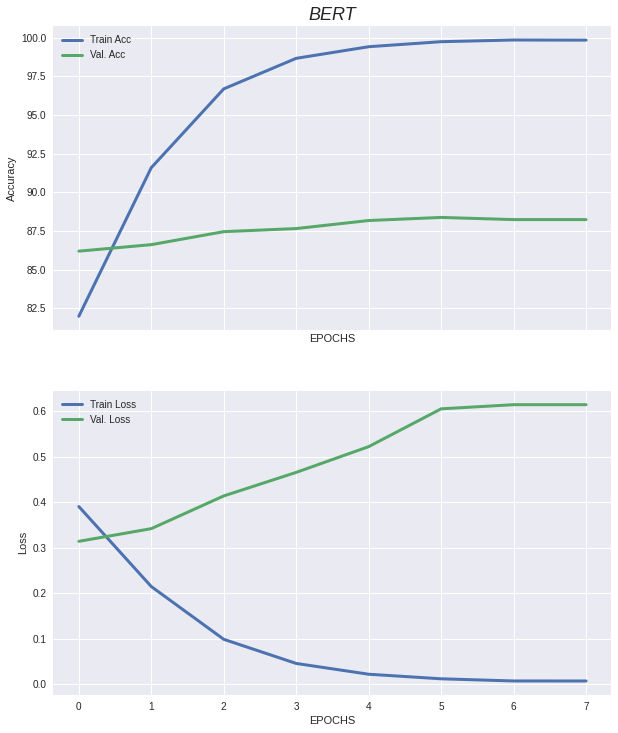

In [63]:
plot_results("BERT")

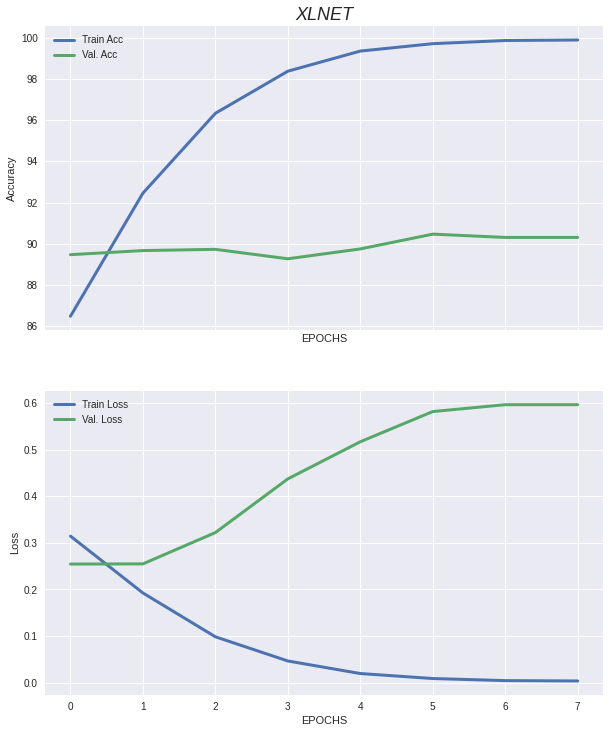

In [64]:
plot_results("XLNET")

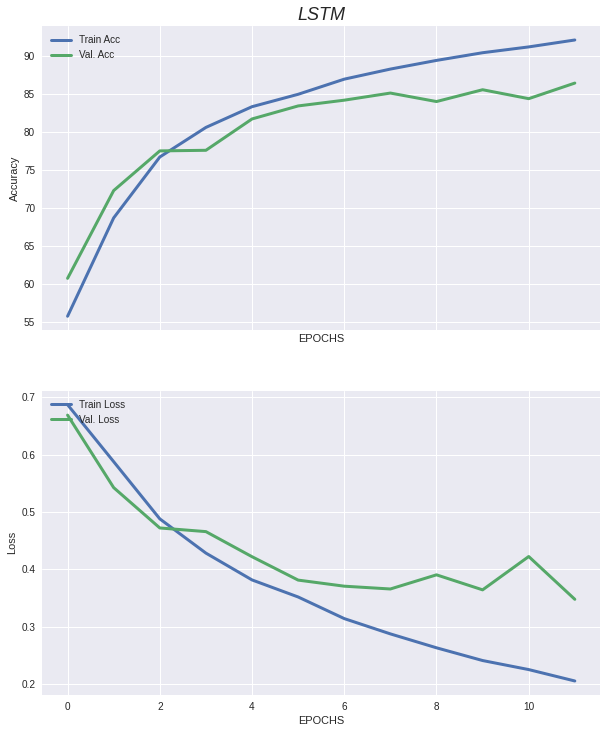

In [65]:
plot_results("LSTM")

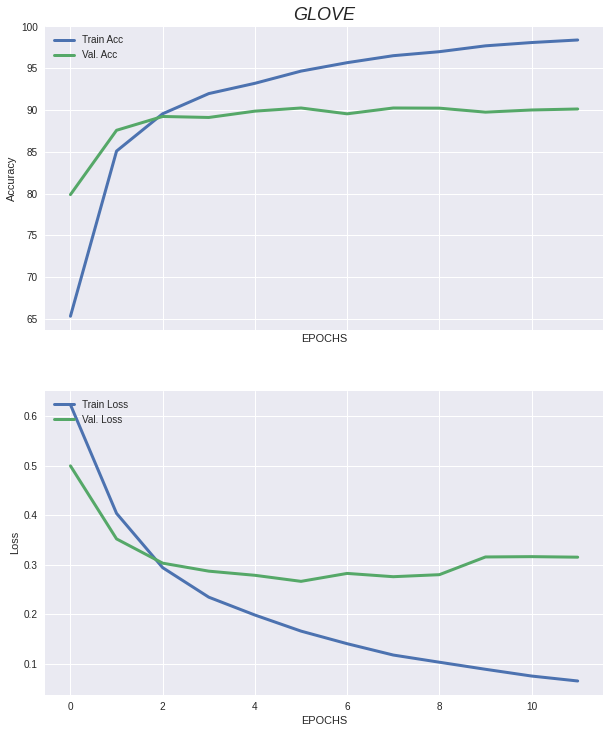

In [66]:
plot_results("GLOVE")

In [83]:
time_and_test = np.zeros((4,3))
for i in range(4):
  for idx,j in enumerate(["Training time",'test. Acc','test. loss']):
    time_and_test[i,idx]=results[models_name[i]][j]
time_and_test = pd.DataFrame(time_and_test,columns = ["Training time",'test. Acc','test. loss'], index = models_name)
time_and_test

,Training time,test. Acc,test. loss
BERT,2207.946019,0.879720,0.618072
XLNET,3046.756292,0.897280,0.607418
LSTM,1430.162652,0.865010,0.355070
GLOVE,81.735415,0.896539,0.337528
